In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Original"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.ppm'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.ppm'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Class:     fraterculus	Number of images: 100
Label: 1	Class:         obliqua	Number of images: 101
Label: 2	Class:       sororcula	Number of images: 100
Processing images ...
Images processed: 301


In [4]:
X.shape

(301, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
list_paths

['/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F035-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F025-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F084-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F062-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F021-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F042-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F098-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F115-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F048-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F010-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F022-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F006-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F055-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F110-G-1,5x.ppm'

In [7]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skfind = []
test_fold = np.zeros((num_samples,), dtype=int)-1
for i in range(kfold):
    train_ind = []
    print('Datasets/Folds/Fold-Train%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Train%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            print('[%d] %s' %(list_paths.index([s for s in list_paths if fname in s][0]),fname))
            train_ind.append(list_paths.index([s for s in list_paths if fname in s][0]))
    print('[%d] Train fold size: %d' %(i,len(train_ind)))
    print(train_ind)
    test_ind = []
    print('Datasets/Folds/Fold-Test%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Test%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            sample_idx = list_paths.index([s for s in list_paths if fname in s][0])
            print('[%d] %s' %(sample_idx,fname))
            test_ind.append(sample_idx)
            test_fold[sample_idx] = i
    print('[%d] Test fold size: %d' %(i,len(test_ind)))
    print(test_ind)
    #skfind.append((np.array(train_ind),np.array(test_ind)))
    skfind.append((train_ind,test_ind))
print('SKFIND')
print(skfind)
print('TEST_FOLD')
print(test_fold)

Datasets/Folds/Fold-Train1.txt
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] F090-G-1,5x.ppm
[44] F093-G-1,5x.ppm
[15] F094-G-1,5x.ppm
[63] F095-G-1,5x.ppm
[99] F106-G-1,5x.ppm
[53] F108-G-1,5x.ppm
[47] F132-N-1,5x.ppm
[254] S093-1,5x.ppm
[216] S094-1,5x.ppm
[288] S095-1,5x.ppm
[213] S096-1,5x.ppm
[279] S098-1,5x.ppm
[207] S099-1,5x.ppm
[209] S100-1,5x.ppm
[259] S101-1,5x.ppm
[300] s102-1,5x.ppm
[268] S103-1,5x.ppm
[278] S104-1,5x.ppm
[251] S105-1,5x.ppm
[267] S106-1,5x.ppm
[281] S108-1,5x.ppm
[244] S109-1,5x.ppm
[229] S111-1,5x.ppm
[247] S112-1,5x.ppm
[208] S116-1,5x.ppm
[261] S118-1,5x.ppm
[234] S123-1,5x.ppm
[131] B001-1,5x.ppm
[193] B003,1,5x.ppm
[140] B009-1,5x.ppm
[167] B012-1,5X.ppm
[195] B018-1,5x.ppm
[162] B019-1,5x.ppm
[158] B024-1,5x.ppm
[110] B032-1,5x.ppm
[137] B038-

[291] S006-1,5x.ppm
[285] S007-1,5x.ppm
[290] S008-1,5x.ppm
[274] S009-1,5x.ppm
[226] S010-1,5x.ppm
[205] S011-1,5x.ppm
[232] S012-1,5x.ppm
[228] S015-1,5x.ppm
[203] S016-1,5x.ppm
[240] S018-1,5x.ppm
[242] S019-1,5x.ppm
[282] S020-1,5x.ppm
[211] S021-1,5x.ppm
[271] S022-1,5x.ppm
[294] S023-1,5x.ppm
[224] S024-1,5x.ppm
[152] B077-G-1,5x.ppm
[176] B074-G-1,5x.ppm
[160] B056-1,5x.ppm
[155] B061-M-1,5x.ppm
[189] B020-1,5x.ppm
[180] B015-1,5x.ppm
[146] B101-G-1,5x.ppm
[126] B082-G-1,5x.ppm
[115] B093-G-1,5x.ppm
[182] B042-1,5x.ppm
[166] B062-G-1,5x.ppm
[141] B002-1,5x.ppm
[139] B033-15,x.ppm
[130] B049-1,5x.ppm
[145] B083-G-1,5x.ppm
[138] B075-G-1,5x.ppm
[112] B096-G-1,5x.ppm
[135] B086-G-1,5x.ppm
[173] B071-G-1,5x.ppm
[101] B027-1,5x.ppm
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] 

In [8]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [9]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [10]:
resnet50features.shape

(301, 2048)

In [11]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    y_train = y[train_indices]
    X_test = resnet50features[test_indices]
    y_test = y[test_indices]
    
    top_model = XGBClassifier()
    top_model.fit(X_train,y_train)  # Training
    pred = top_model.predict(X_test)  # Testing
    y_pred = [round(value) for value in pred]
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.7667
[1] Test acurracy: 0.8033
[2] Test acurracy: 0.8667
[3] Test acurracy: 0.8333
[4] Test acurracy: 0.8333


In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8206


Plotting the confusion matrix


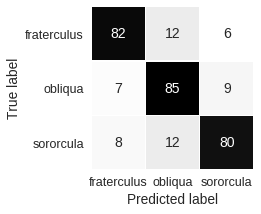

In [13]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


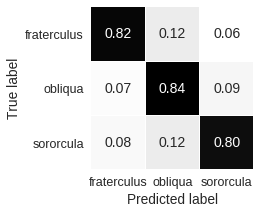

In [14]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()